In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(gridtext))

In [2]:
clinical_xl <- read_excel("table_s1.xlsx", sheet = "Clinical_data"
        ) %>% select("case_id","histology_diagnosis")
molecular_xl <- read_excel("table_s1.xlsx", sheet = "Molecular_phenotype_data"
        ) %>% select("case_id","epithelial_cancer_deconv", "neoplastic_cellularity_histology_estimate", "chrIdx")
# Combine the data on case_id
data_xl <- clinical_xl %>%
  left_join(molecular_xl, by = "case_id") %>%
  mutate(chrIdx = chrIdx) %>%
  mutate(epithelial_cancer_deconv = epithelial_cancer_deconv) %>%
  mutate(neoplastic_cellularity_histology_estimate = neoplastic_cellularity_histology_estimate) %>%
  mutate(histology_diagnosis = as.character(histology_diagnosis)) %>%
  mutate(chrIdx =chrIdx)
head(data_xl)

case_id,histology_diagnosis,epithelial_cancer_deconv,neoplastic_cellularity_histology_estimate,chrIdx
<chr>,<chr>,<chr>,<dbl>,<dbl>
C3L-00102,PDAC,0.15057499462926499,0.2380952,1.1361462
C3L-00189,PDAC,8.3229411005776299E-2,0.1311475,0.9253992
C3L-00277,PDAC,0.45865917198488698,0.3921569,2.9961089
C3L-00401,PDAC,9.1309880486436998E-2,0.4006410,1.0524329
C3L-00640,PDAC,0.20410882160947499,0.3623188,2.0215790
C3L-00819,PDAC,0.262587404952142,0.3333333,2.7450123


In [57]:
# d_xl <- read_excel("table_s1.xlsx", sheet = "Molecular_phenotype_data",
#                 ) %>% select(case_id, KRAS_VAF)
# Read tsv
c_df <- read.table("data/1c-caseid_kras_vaf_smad4_tp53_cdk2a_mutation_amp_del.tsv", sep = "\t", header = TRUE, stringsAsFactors = FALSE)
c_df$KRAS <- as.numeric(ifelse(c_df$KRAS_VAF == "NA", NA, c_df$KRAS_VAF))

# ## Exceptions : they had high mutation burden (n > 25), high CNV (index > 1), and/or additional driver events in TP53, CDKN2A, and SMAD4

c_df <- c_df %>% 
    mutate(
    # Set Tumor_Cellularity based on KRAS_VAF
    Tumor_Cellularity = ifelse(KRAS_VAF >= 0.075, "Sufficient", "Low"),
    # Override Tumor_Cellularity for specific case_ids
    Tumor_Cellularity = ifelse(case_id %in% c("C3N-00198", "C3N-01380", "C3N-01715", "C3N-03426"),
                               "Sufficient", Tumor_Cellularity),
    Tumor_Cellularity = ifelse(case_id %in% c("C3N-01012"),
                               "Low", Tumor_Cellularity),
    # Replace NA in KRAS_VAF with 0
    KRAS_VAF = ifelse(is.na(KRAS_VAF), 0, KRAS_VAF)
  )

# Join with the data_xl
c_df <- c_df %>%
  left_join(data_xl, by = "case_id") %>%
  mutate(chrIdx = chrIdx) %>%
  mutate(epithelial_cancer_deconv = as.numeric(ifelse(epithelial_cancer_deconv == "NA", NA, epithelial_cancer_deconv))) %>%
  mutate(neoplastic_cellularity_histology_estimate = neoplastic_cellularity_histology_estimate) %>%
  mutate(neoplastic_cellularity_histology_estimate = as.numeric(ifelse(neoplastic_cellularity_histology_estimate == "NA", NA, neoplastic_cellularity_histology_estimate))) %>%
  mutate(histology_diagnosis = as.character(histology_diagnosis)) %>%
  mutate(chrIdx =chrIdx) %>%
  mutate(del = del)%>%
  arrange(Tumor_Cellularity, desc(neoplastic_cellularity_histology_estimate)) 

  
  # %>%
  # mutate( SMAD4 = ifelse(SMAD4 == "Nonsense_Mutation" | SMAD4 == "Frame_Shift_Del" | SMAD4 == "Frame_Shift_Ins", "Nonsense/frameshift",
  #                   ifelse(SMAD4 == "Missense_Mutation", "Missense",
  #                          ifelse(SMAD4 == "In_Frame_Del" | SMAD4 == "In_Frame_Ins", "In-frame ins/del", "WT"))),
  #        TP53 = ifelse(TP53 == "Nonsense_Mutation" | TP53 == "Frame_Shift_Del" | TP53 == "Frame_Shift_Ins", "Nonsense/frameshift",
  #                   ifelse(TP53 == "Missense_Mutation", "Missense",
  #                          ifelse(TP53 == "In_Frame_Del" | TP53 == "In_Frame_Ins", "In-frame ins/del", "WT"))),
  #        CDKN2A = ifelse(CDKN2A == "Nonsense_Mutation" | CDKN2A == "Frame_Shift_Del" | CDKN2A == "Frame_Shift_Ins", "Nonsense/frameshift",
  #                   ifelse(CDKN2A == "Missense_Mutation", "Missense",
  #                          ifelse(CDKN2A == "In_Frame_Del" | CDKN2A == "In_Frame_Ins", "In-frame ins/del", "WT"))))


tail(c_df,10)
# summary(c_df)

,case_id,KRAS,KRAS_VAF,mutation_count,CDKN2A,SMAD4,TP53,amp,del,Tumor_Cellularity,histology_diagnosis,epithelial_cancer_deconv,neoplastic_cellularity_histology_estimate,chrIdx
,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
131,C3L-01687,0.1341990,0.1341990,27,Missense,WT,In-frame ins/del,381,-945,Sufficient,PDAC,0.24532493,0.14238411,1.6645924
132,C3N-01380,NA,0.0000000,14,WT,WT,Nonsense/frameshift,245,-60,Sufficient,PDAC,NA,0.12500000,1.8670334
133,C3L-02109,0.1425660,0.1425660,31,WT,WT,Missense,1079,-2025,Sufficient,PDAC,0.27306862,0.12500000,2.4621627
134,C3N-03190,0.2372880,0.2372880,20,WT,WT,Missense,834,-107,Sufficient,PDAC,NA,0.10000000,2.0662956
135,C3N-03840,0.1283100,0.1283100,25,WT,WT,WT,386,-77,Sufficient,PDAC,NA,0.09950249,1.7446854
136,C3N-03439,0.0905512,0.0905512,60,WT,WT,Missense,1834,-30,Sufficient,PDAC,NA,0.08000000,1.5467228
137,C3L-04853,0.0955882,0.0955882,36,WT,WT,WT,240,-41,Sufficient,PDAC,0.25430444,0.05076142,1.7740580
138,C3L-01971,0.3347830,0.3347830,48,Nonsense/frameshift,Nonsense/frameshift,Missense,918,-30,Sufficient,PDAC,0.23508468,0.05000000,2.5983632
139,C3L-02890,0.1233600,0.1233600,32,Nonsense/frameshift,WT,Nonsense/frameshift,357,-28,Sufficient,PDAC,0.18638932,0.04500000,1.1108455


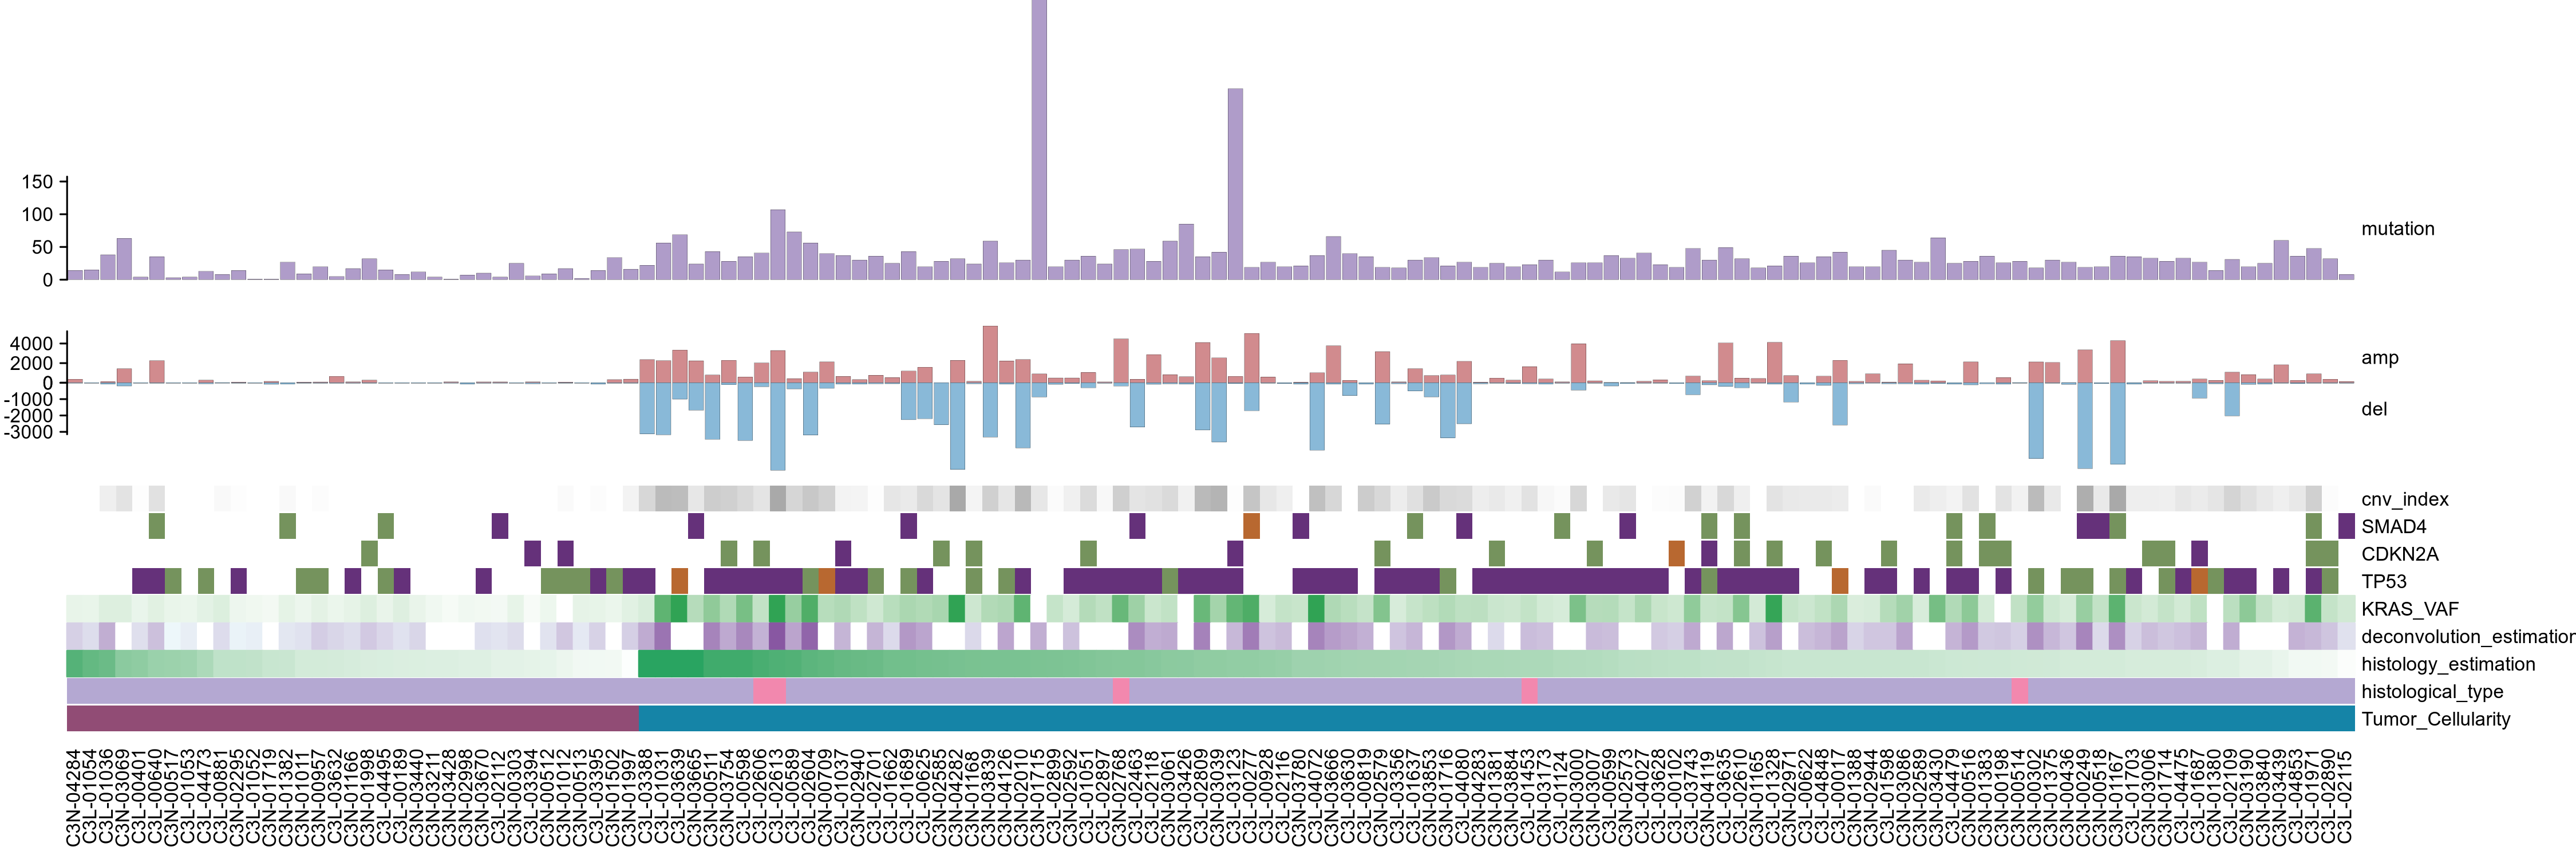

In [93]:
options(repr.plot.width=15, repr.plot.height=5, repr.plot.res = 300)
zero_mat <- matrix(nrow = 0, ncol = nrow(c_df))


# ht_opt(annotation_column_title_gp = gpar(fontsize = 10),
#        annotation_legend_label_gp = gpar(fontsize = 8),
#        annotation_legend_title_gp = gpar(fontsize = 8),
#        heatmap_legend_param = list(title_gp = gpar(fontsize = 8), labels_gp = gpar(fontsize = 8)),
#        column_title_gp = gpar(fontsize = 10),
#        row_title_gp = gpar(fontsize = 10),
#        column_names_gp = gpar(fontsize = 8),
#        row_names_gp = gpar(fontsize = 8)
# )
cnv_color = colorRamp2(c(1, 4),c("white", "darkgrey"))
kras_color = colorRamp2(c(0, 0.4), c("white", "#30A354"))
deconv_color = colorRamp2(c(0, 0.6), c("#EEF9FB", "#8857A2"))
histological_color = colorRamp2(c(0, 0.7), c("white", "#29A461"))
# cnv_lgd = Legend(at = c(1, 4), legend_gp = gpar(fill = cnv_color(1:2)))
ANNO_HEIGHT = 0.15
GAP1=0.01
GAP2=0.3
 

c_mutation <- HeatmapAnnotation(
    mutation = anno_barplot(
        c_df$mutation_count, width = unit(8, "in"),
        bar_width = 0.9, border = FALSE,
        ylim = c(0,150), 
        gp = gpar(fill = "#AF9CC9", lwd = 0.1, color = "white")
    ),
    amp = anno_barplot(
        c_df$amp, ylim=c(0,5000), border = FALSE,
        width = unit(8,"in"), bar_width = 0.9,
        gp = gpar(fill = "#D18B8E", lwd = 0.1, color = "white")
    ),
    del = anno_barplot(
        c_df$del, ylim=c(-3000,0), border = FALSE,
        width = unit(8,"in"), bar_width = 0.9,
        gp = gpar(fill = "#89B9D8", lwd = 0.1, color = "white")
    ),
    # cnv_index = anno_simple(c_df$chrIdx, border = FALSE),
    # SMAD4 = anno_simple(c_df$SMAD4, border = FALSE),
    # CDKN2A = anno_simple(c_df$CDKN2A, border = FALSE),
    # TP53 = anno_simple(c_df$TP53, border = FALSE),
    # KRAS_VAF = anno_simple(c_df$KRAS_VAF, border = FALSE),
    # deconvolution_estimation = anno_simple(c_df$epithelial_cancer_deconv, border = FALSE),
    # histology_estimation = anno_simple(c_df$neoplastic_cellularity_histology_estimate, border = FALSE),
    # histological_type = anno_simple(c_df$histology_diagnosis, border = FALSE),
    # Tumor_Cellularity = anno_simple(c_df$Tumor_Cellularity, border = FALSE),

    cnv_index = c_df$chrIdx,    
    SMAD4 = c_df$SMAD4,
    CDKN2A = c_df$CDKN2A,
    TP53 = c_df$TP53,
    # KRAS_VAF = c_df$KRAS_VAF,
    KRAS_VAF = anno_simple(c_df$KRAS_VAF, border = FALSE, na_col = "white", col = kras_color, ),
    # deconvolution_estimation = c_df$epithelial_cancer_deconv,
    deconvolution_estimation = anno_simple(c_df$epithelial_cancer_deconv, border = FALSE, na_col = "white", col = deconv_color),
    # histology_estimation = c_df$neoplastic_cellularity_histology_estimate,
    histology_estimation = anno_simple(c_df$neoplastic_cellularity_histology_estimate, border = FALSE, na_col = "white", col = histological_color),
    histological_type = c_df$histology_diagnosis,
    Tumor_Cellularity = c_df$Tumor_Cellularity,

    col = list(
        # mutation = c("purple"),
        cnv_index = cnv_color,

        # KRAS_VAF = kras_color,
        SMAD4 = c("Nonsense/frameshift" = "#75935D", "Missense" = "#65317A", "In-frame ins/del" = "#B86830", "WT"="white"), 
        CDKN2A = c("Nonsense/frameshift" = "#75935D", "Missense" = "#65317A", "In-frame ins/del" = "#B86830", "WT" = "white"),
        TP53 = c("Nonsense/frameshift" = "#75935D", "Missense" = "#65317A", "In-frame ins/del" = "#B86830", "WT" = "white"),
        histological_type = c("PDAC"= "#B4A8D2", "Adenosquamous carcinoma" = "#F288AE"),
        Tumor_Cellularity = c("Sufficient" = "#1584A7", "Low" = "#914C75")
    ),
    show_legend = c(FALSE,FALSE,FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE),
    annotation_height = unit(c(0.6, 0.3, 0.3,ANNO_HEIGHT, ANNO_HEIGHT, ANNO_HEIGHT, ANNO_HEIGHT, ANNO_HEIGHT, ANNO_HEIGHT, ANNO_HEIGHT, ANNO_HEIGHT, ANNO_HEIGHT), "in"), 
    height = unit(0, "in"),
    gap = unit(c(GAP2,0,GAP2,GAP1,GAP1,GAP1,GAP1,GAP1,GAP1,GAP1,GAP1),"in"),
    annotation_name_gp = gpar(fontsize = 8)
)



c_ht <- Heatmap(
    zero_mat, top_annotation = c_mutation,
    column_labels = gt_render(
        x = c_df$case_id, 
        padding = unit(c(0,0,0,0), "pt")
    ),
    column_names_gp = gpar(fontsize = 8),
    # col = c("white", "black"), 
    # column_title = "KRAS VAF",# column_title_gp = gpar(fontsize = 20),
    # row_title = "Case ID",# row_title_gp = gpar(fontsize = 20),
    # show_row_names = FALSE,# show_column_names = FALSE,
    # cluster_columns = FALSE,# cluster_rows = FALSE,
    # right_annotation = NULL
) 

draw(c_ht,
    padding = unit(c(-1, 0, 0, 0), "in"),)

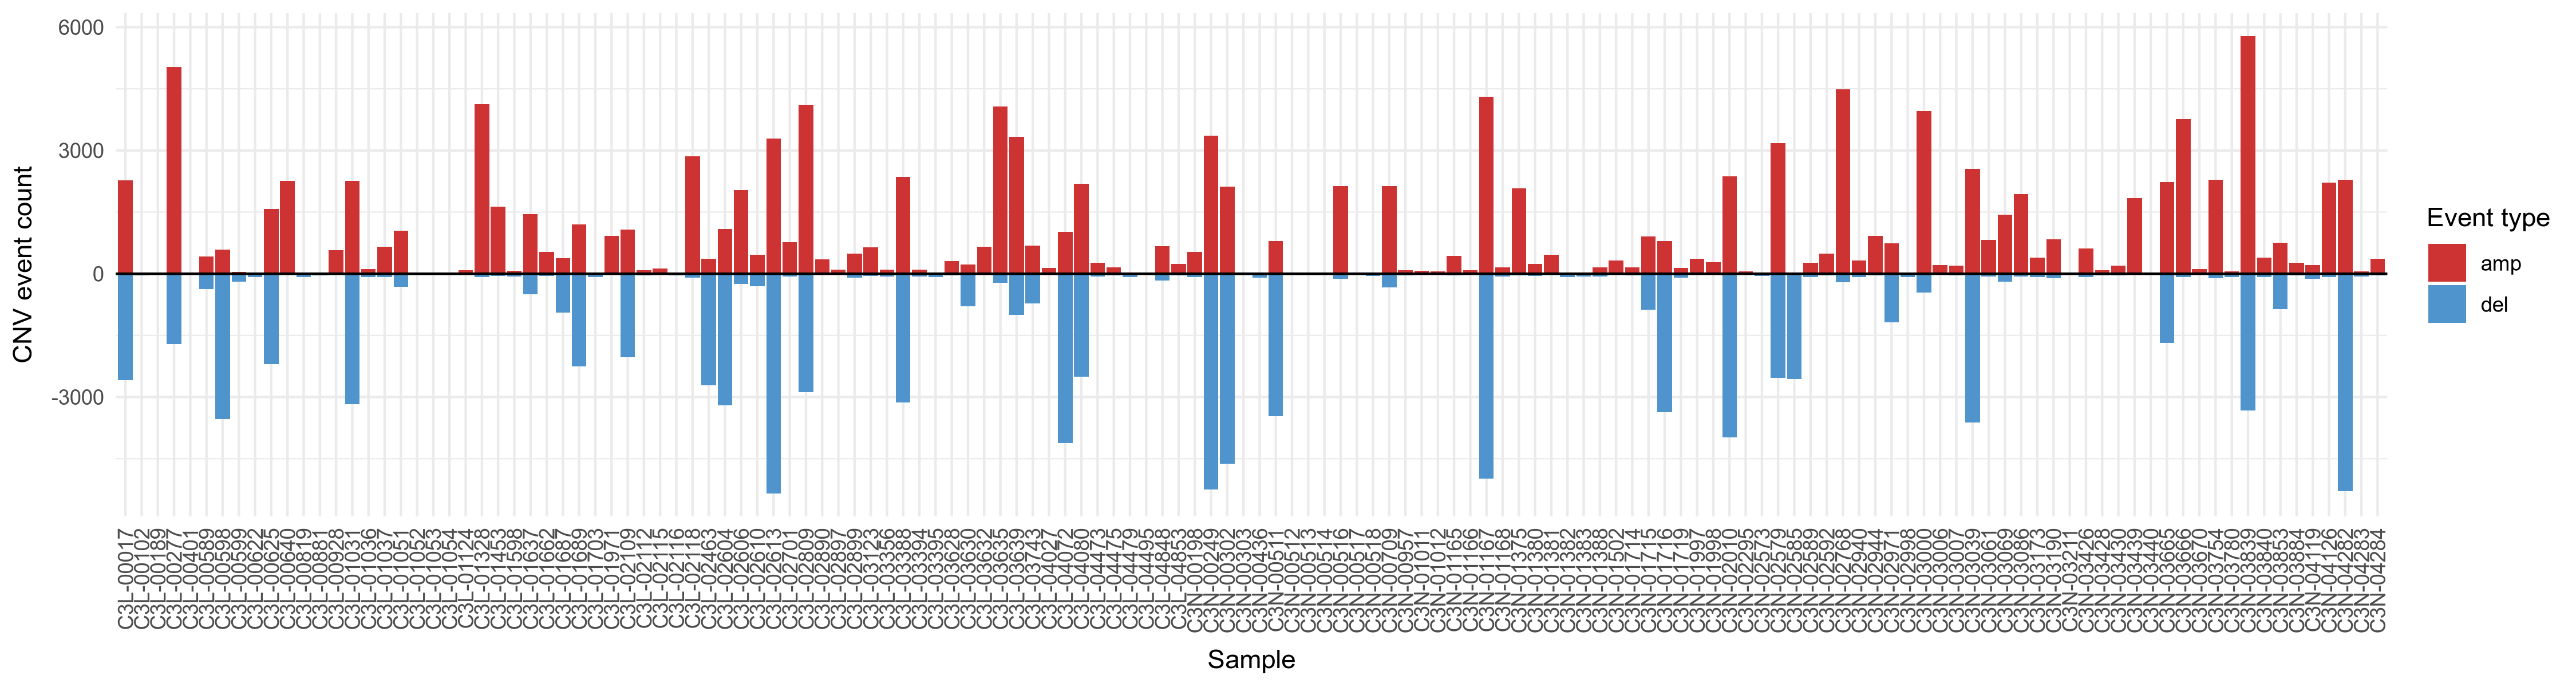

In [35]:
plot_df <- c_df %>%
#   mutate(del = -del) %>%
  pivot_longer(cols = c("amp", "del"), names_to = "type", values_to = "value") %>% 
  select(case_id, type, value)

# # barplot
ggplot(plot_df, aes(x = case_id, y = value, fill = type)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = c("amp" = "brown3", "del" = "steelblue3")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  labs(y = "CNV event count", x = "Sample", fill = "Event type") +
  geom_hline(yintercept = 0, color = "black")